In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

<h2 align="center" style="color:blue">Data Loading</h2>

In [3]:
df = pd.read_excel("data/premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [4]:
df.shape

(50000, 13)

In [5]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


<h2 align="center" style="color:blue">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [6]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


#### Data Cleaning: number_of_dependants 

In [10]:
df[df['number_of_dependants']<0]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
402,23,Female,Southwest,Unmarried,-3,Underweight,No Smoking,Freelancer,10L - 25L,18,No Disease,Silver,9309
2245,18,Male,Southwest,Unmarried,-3,Overweight,No Smoking,Freelancer,25L - 40L,28,No Disease,Silver,8095
2323,19,Male,Northwest,Unmarried,-3,Underweight,No Smoking,Freelancer,25L - 40L,40,No Disease,Bronze,4641
2986,34,Female,Southeast,Married,-1,Underweight,Regular,Self-Employed,25L - 40L,35,High blood pressure & Heart disease,Silver,22995
3756,41,Male,Southwest,Married,-1,Obesity,Regular,Salaried,10L - 25L,21,Diabetes,Silver,22766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48062,23,Male,Northwest,Unmarried,-1,Normal,No Smoking,Freelancer,> 40L,54,No Disease,Gold,13601
48086,36,Female,Southwest,Married,-1,Obesity,Occasional,Salaried,<10L,3,Diabetes,Bronze,14422
49256,60,Female,Southwest,Married,-1,Normal,No Smoking,Self-Employed,10L - 25L,21,Thyroid,Bronze,10141
49270,34,Male,Southeast,Married,-1,Obesity,No Smoking,Self-Employed,10L - 25L,17,Diabetes & Thyroid,Silver,21816


In [11]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

We can see some negative values in number_of_dependants. We can replace them with positive numbers.

In [12]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [13]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

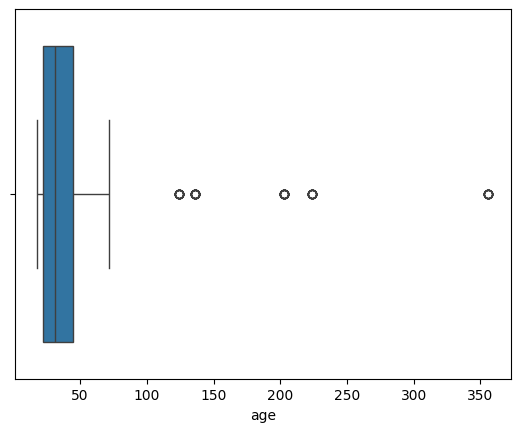

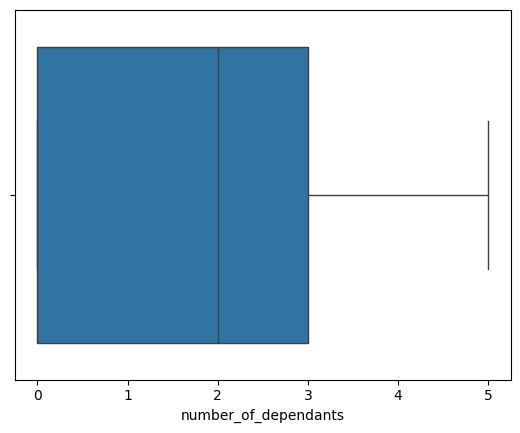

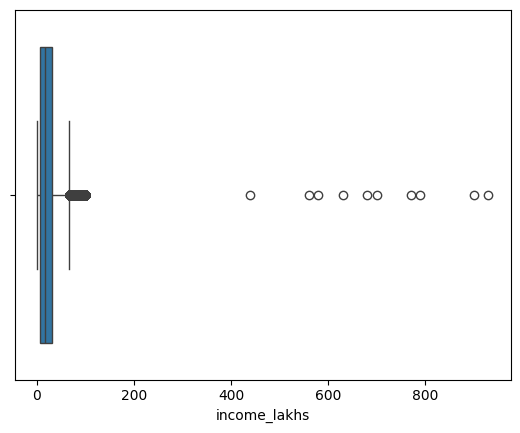

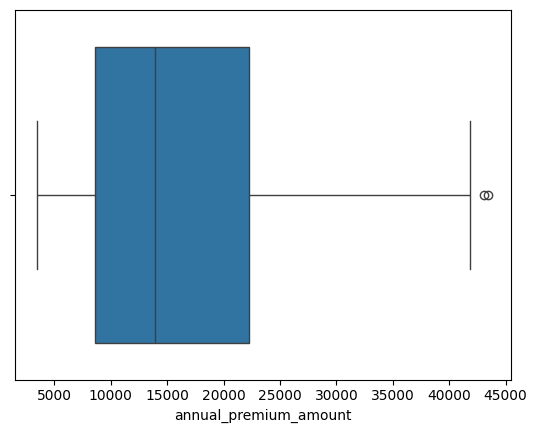

In [14]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

### Outlier Treatment: Age Column

In [15]:
df[df['age']>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
114,224,Male,Northeast,Married,3,Normal,Regular,Salaried,25L - 40L,26,No Disease,Gold,27523
786,124,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,46,No Disease,Silver,11752
1298,124,Female,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,3,No Disease,Bronze,5311
1456,124,Female,Southwest,Unmarried,1,Overweight,No Smoking,Salaried,<10L,2,Diabetes,Bronze,10238
1470,136,Male,Southeast,Married,3,Overweight,Regular,Self-Employed,10L - 25L,15,High blood pressure,Gold,31913
1773,203,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,6,Diabetes,Bronze,8762
3658,136,Male,Southwest,Married,2,Normal,Regular,Salaried,10L - 25L,20,Diabetes & Thyroid,Gold,31402
4246,203,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,18,No Disease,Bronze,5254
5699,124,Female,Southeast,Unmarried,1,Normal,No Smoking,Self-Employed,25L - 40L,29,No Disease,Silver,10265
5951,136,Male,Southwest,Married,3,Underweight,Regular,Self-Employed,<10L,2,Heart disease,Silver,26127


In [16]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [17]:
df1 = df[df['age']<=100]
df1['age'].describe()

count    49918.000000
mean        34.401839
std         13.681600
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

### Outlier Treatment: Income Column

In [18]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-29.0, 67.0)

In [19]:
df1[df1['income_lakhs']>upper]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
24,55,Male,Southeast,Married,4,Normal,No Smoking,Freelancer,> 40L,83,Thyroid,Gold,26979
34,22,Female,Southwest,Unmarried,0,Normal,No Smoking,Salaried,> 40L,70,No Disease,Silver,11305
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49900,35,Male,Southwest,Married,5,Overweight,No Smoking,Salaried,> 40L,97,No Disease,Gold,22194
49955,43,Male,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,91,High blood pressure,Silver,15342
49975,18,Female,Southeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,89,No Disease,Silver,9783
49993,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,No Disease,Gold,11603


In [20]:
df1[df1['income_lakhs']>upper].shape

(3559, 13)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence, we will use a simple quantile bound.

In [21]:
quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

np.float64(100.0)

In [22]:
df1[df1['income_lakhs'] > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
2635,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4220,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636
7775,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
9021,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
10337,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
10639,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888
11456,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424
15437,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586
35446,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
40970,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


In [23]:
df1[df1['income_lakhs'] > quantile_threshold].shape

(10, 13)

In [24]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold].copy()
df2.shape

(49908, 13)

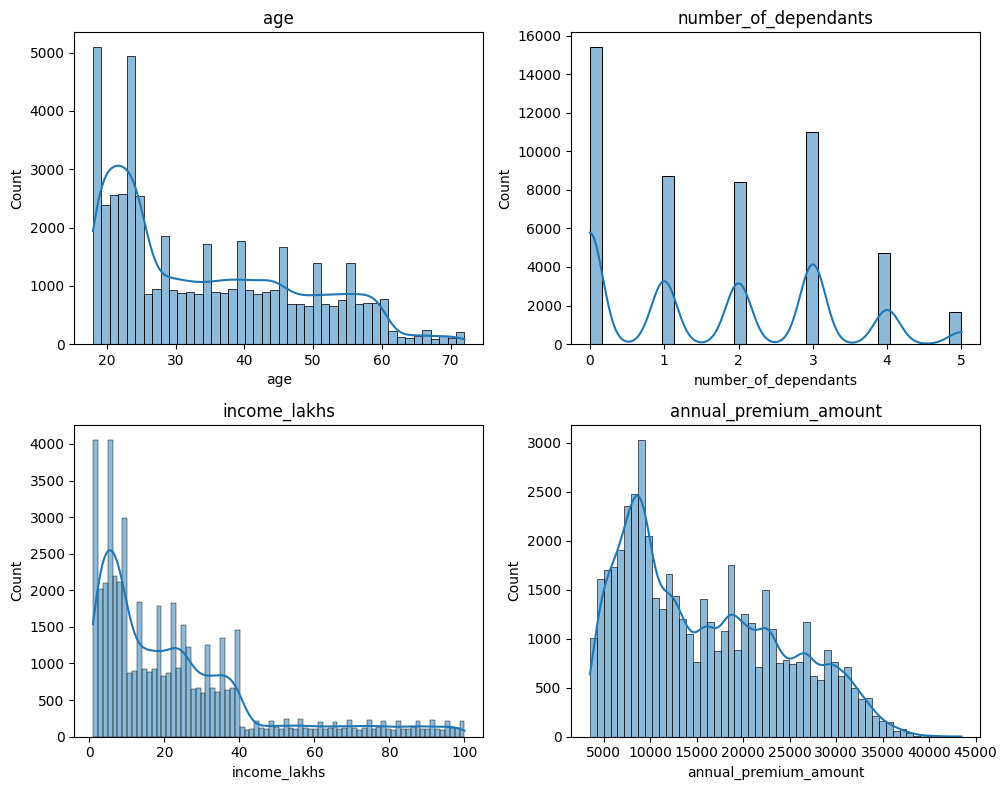

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()

### Bivariate Analysis: Numeric Columns

In [26]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

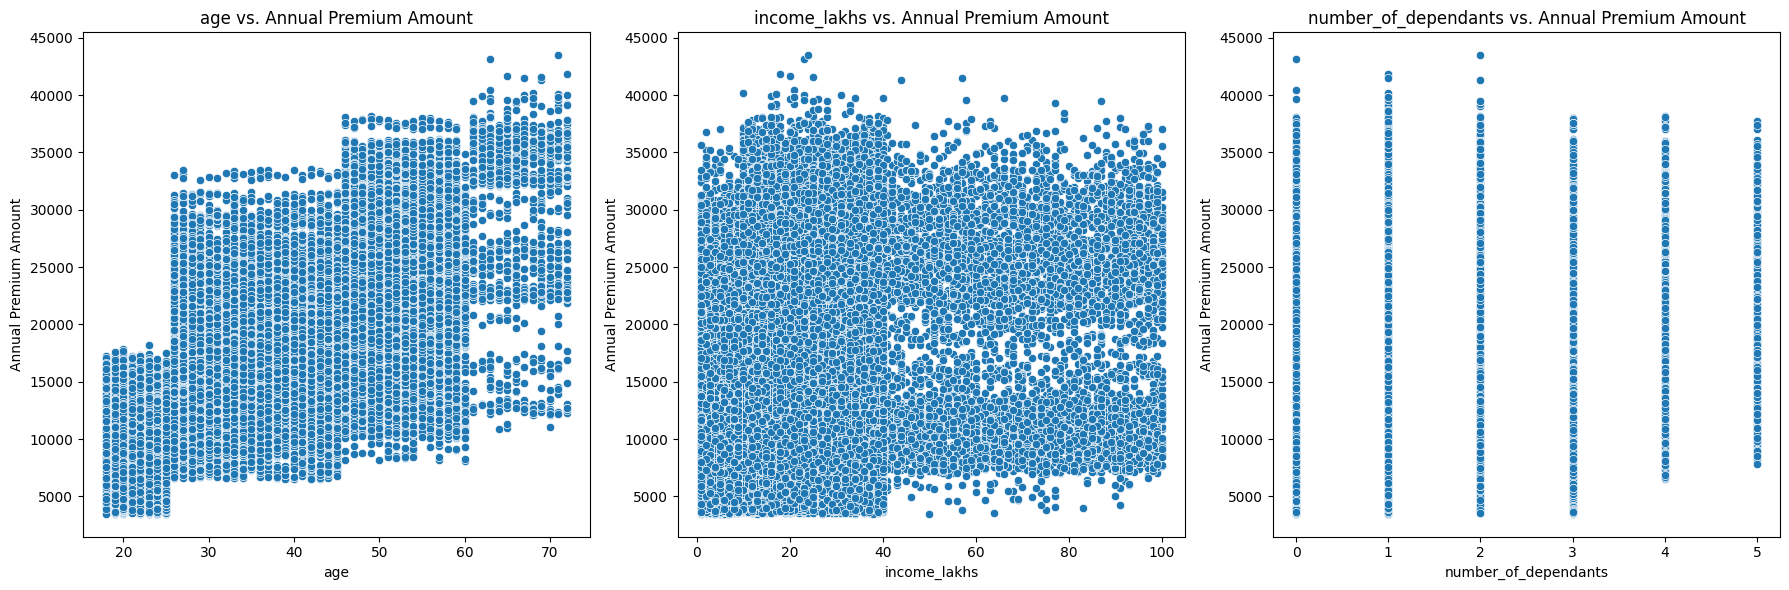

In [27]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18,6))

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f"{column} vs. Annual Premium Amount")
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

## Categorical Columns

In [28]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


#### Data Cleaning: smoking_status

In [29]:
df2['smoking_status'] = df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
})

df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis: Categorical Columns

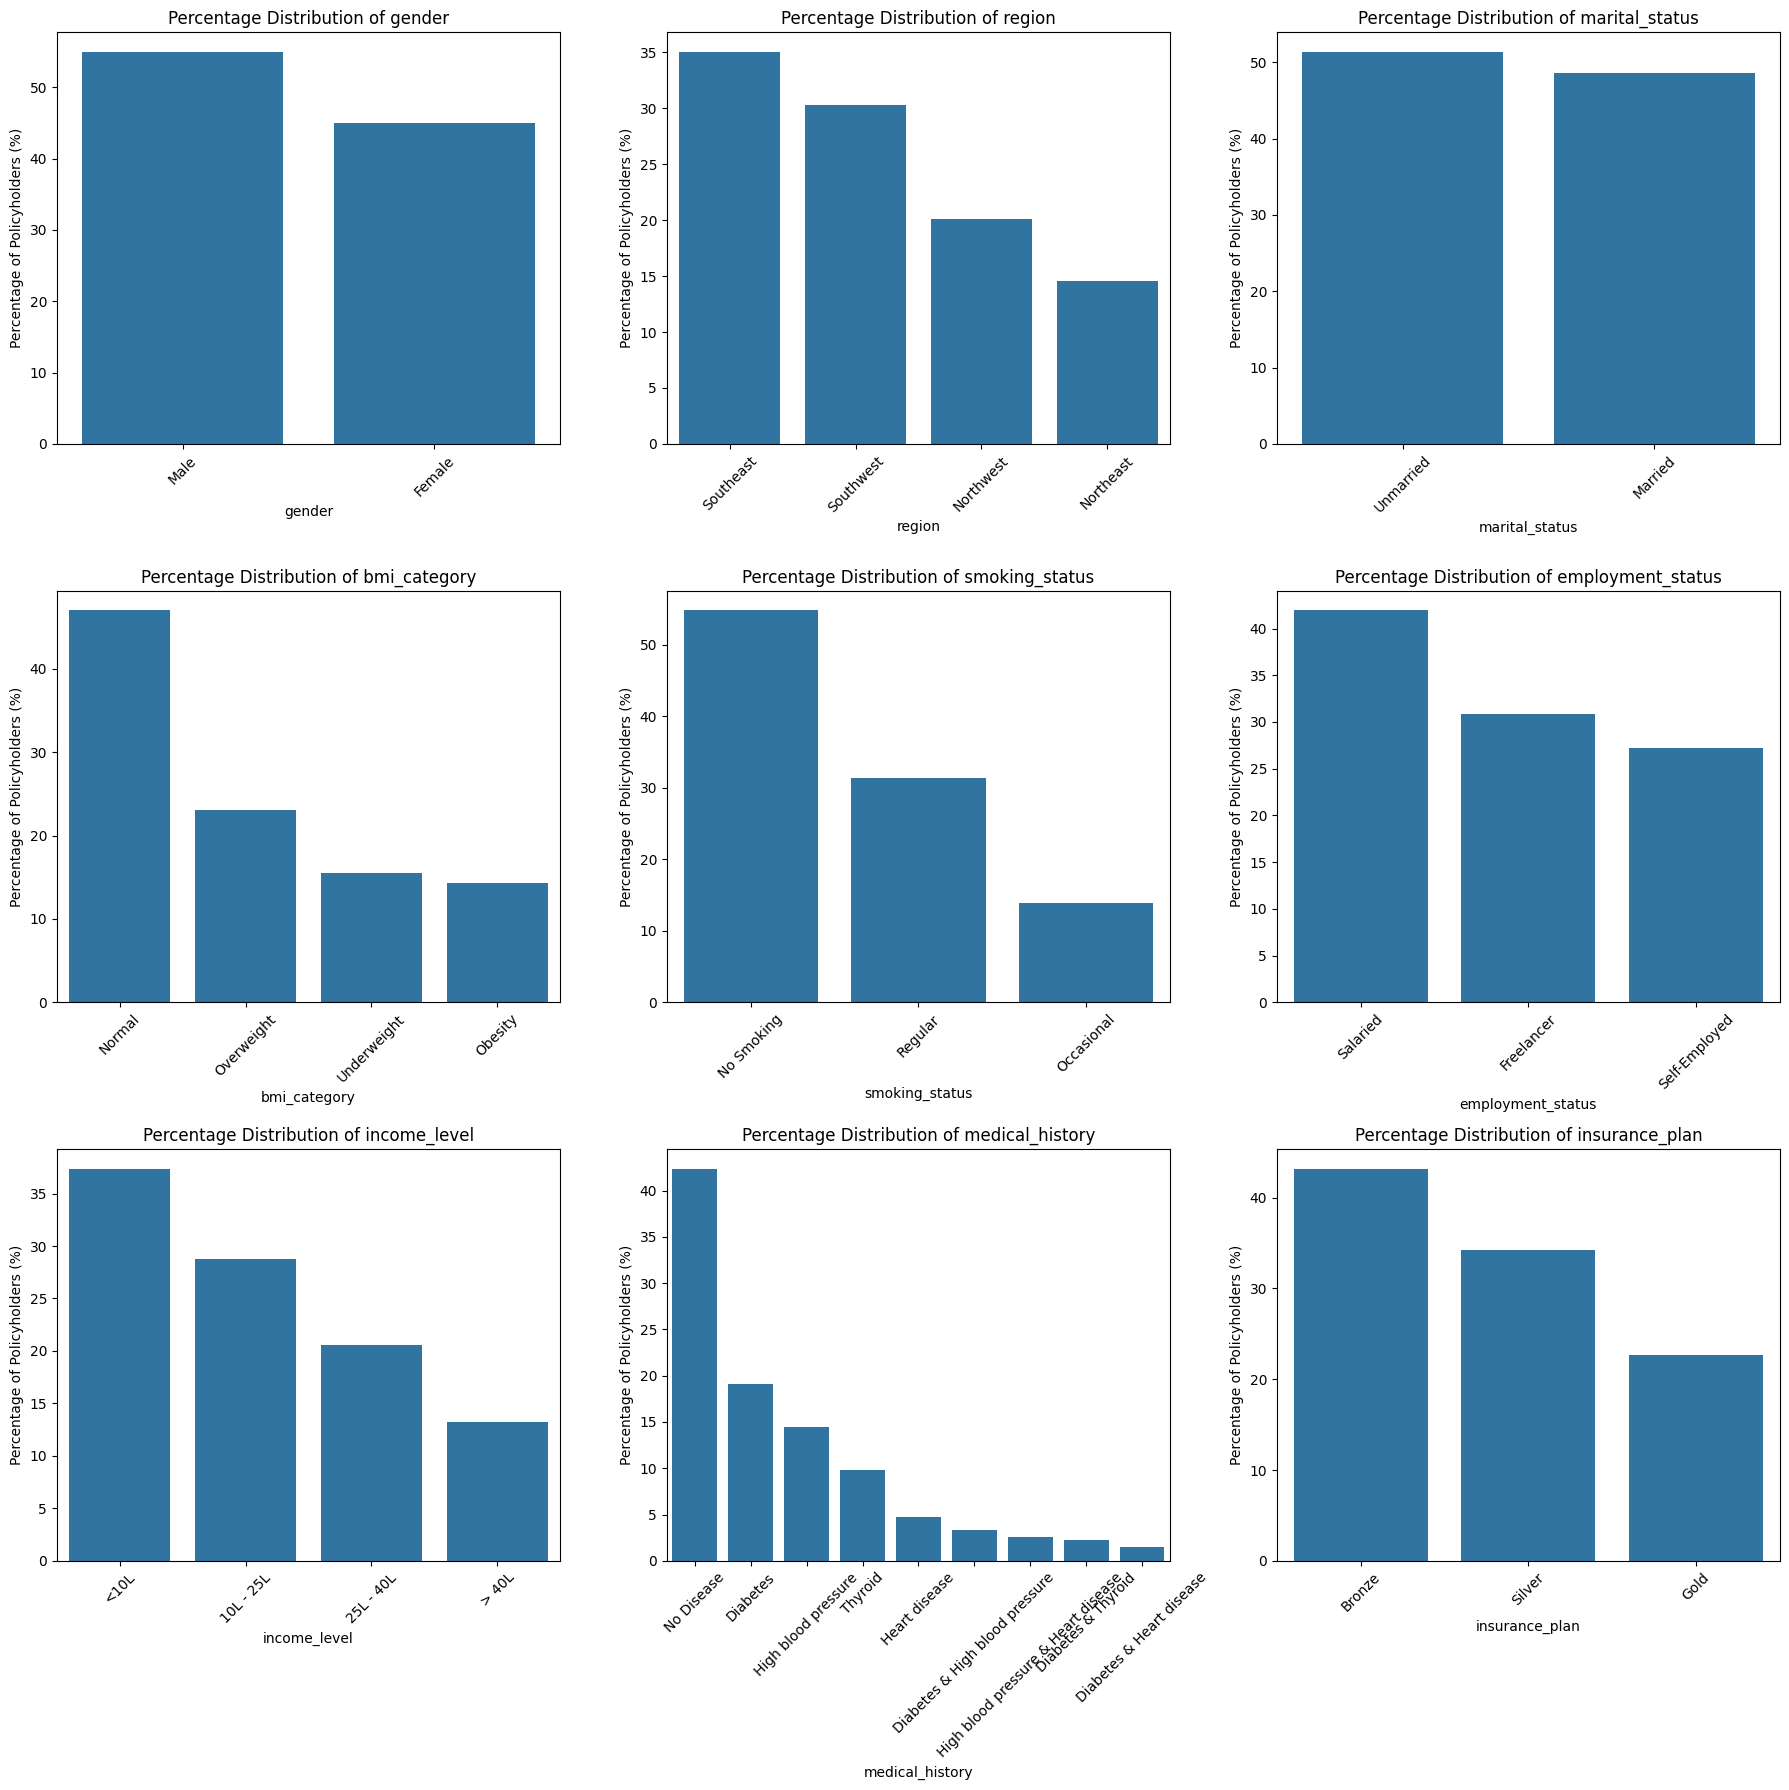

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))
axes = axes.flatten()

for ax, column in zip(axes, categorical_cols):
    category_counts = df2[column].value_counts(normalize=True) * 100

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

### Bivariate Analysis: Categorical Columns

In [31]:
# Cross-tabulation of income_level and insurnace_plan
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,329,3653,2641


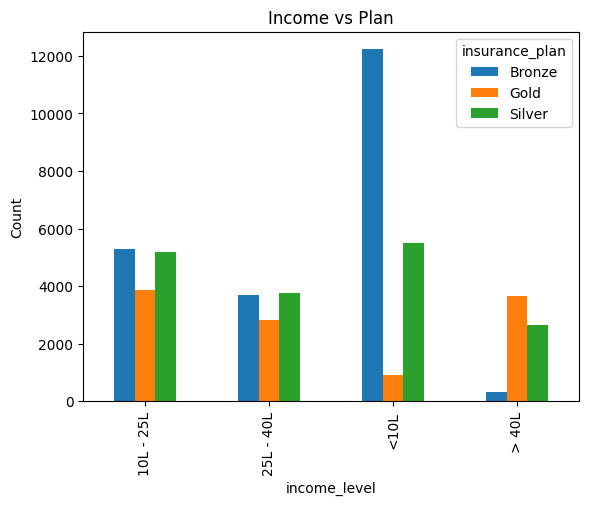

In [32]:
# Plotting the crosstab
crosstab.plot(kind='bar')
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.show()

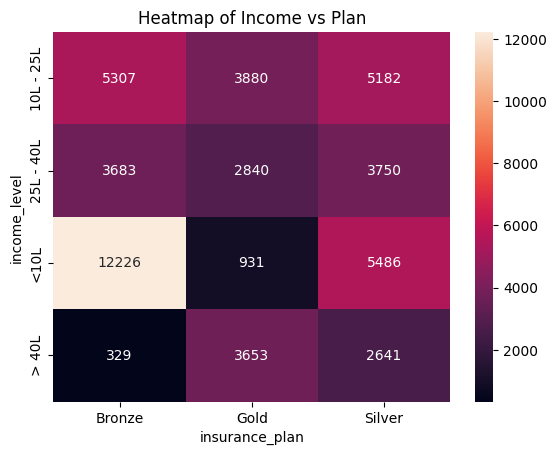

In [33]:
sns.heatmap(crosstab, annot=True,fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center>Feature Engineering</h2>

<h2 align="center" style="color:blue">Feature Engineering</h2>

In [34]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


### Calculate Risk Score

In [35]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [36]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "high blood pressure": 6,
    "heart disease": 8,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571


### Encode Categorical Columns

In [37]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [38]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})

In [39]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [40]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [41]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49908 non-null  int64  
 1   number_of_dependants             49908 non-null  int64  
 2   income_level                     49908 non-null  int64  
 3   income_lakhs                     49908 non-null  int64  
 4   medical_history                  49908 non-null  object 
 5   insurance_plan                   49908 non-null  int64  
 6   annual_premium_amount            49908 non-null  int64  
 7   disease1                         49908 non-null  object 
 8   disease2                         49908 non-null  object 
 9   total_risk_score                 49908 non-null  int64  
 10  normalized_risk_score            49908 non-null  float64
 11  gender_Male                      49908 non-null  int64  
 12  region_Northwest       

<h2 align="center" style="color:blue">Feature Selection</h2>

In [43]:
df4 = df3.drop(columns=['medical_history', 'disease1', 'disease2', 'total_risk_score'])
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


### Calculate VIF for Multicollinearity

In [44]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

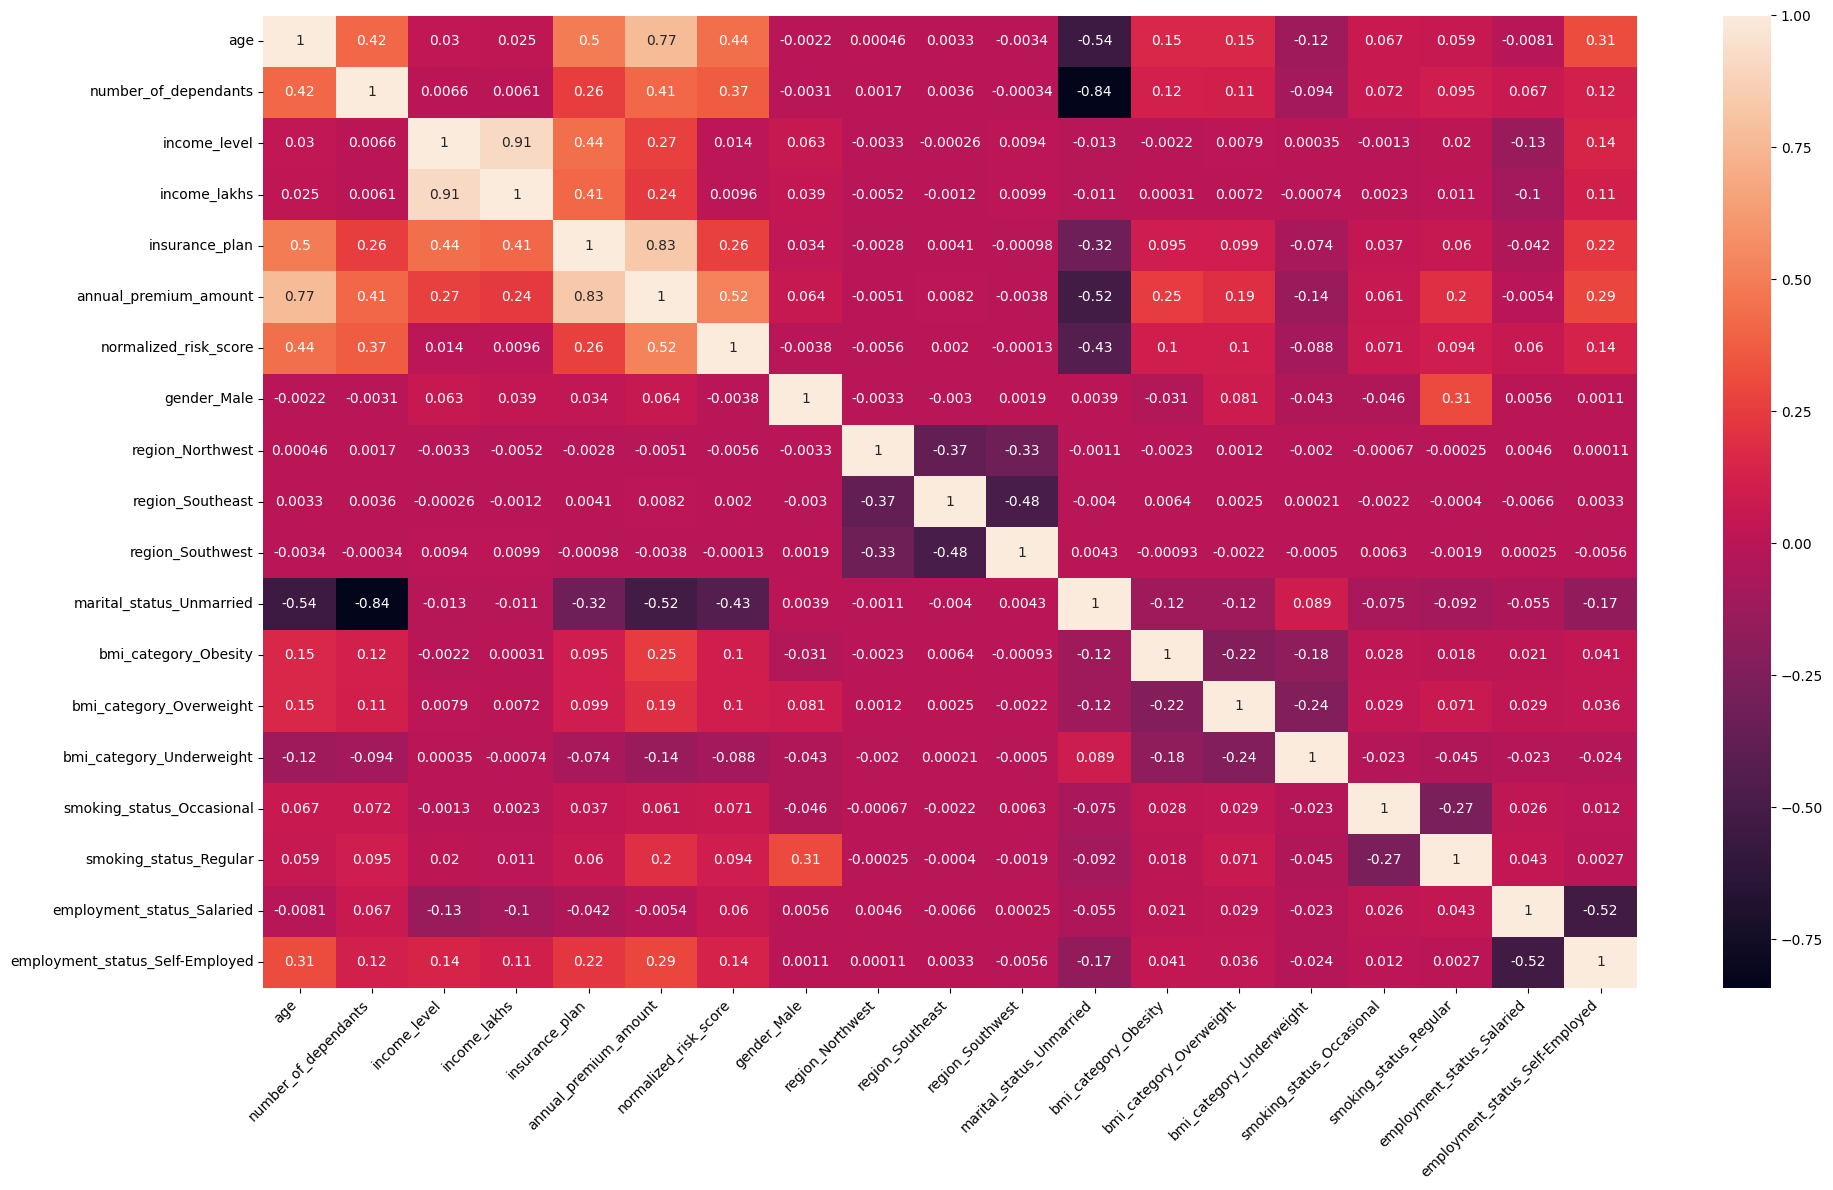

In [45]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
X = df4.drop(['annual_premium_amount'], axis='columns')
y = df4['annual_premium_amount']

cols_to_scale =['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [48]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [49]:
calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [50]:
# We will drop the income_level due to high VIF value
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


<h2 align="center" style="color:blue">Model Training</h2>

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


### Linear Regression Model

In [52]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9280957176093705, 0.9283765993531428)

In [53]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression ==> MSE:",mse_lr, "RMSE:",rmse_lr)

Linear Regression ==> MSE: 5056639.130347775 RMSE: 2248.6972073509087


In [54]:
feature_importance = model_lr.coef_
feature_importance

array([11236.4082633 ,  -536.61172956,  -353.97067084, 12515.43782972,
        4846.88626348,   121.53023031,   -34.50219135,    27.97504587,
         -23.47372614,  -821.78088646,  3356.07750448,  1613.1421694 ,
         364.31350886,   722.41051531,  2261.97816483,   149.57179545,
         378.25130285])

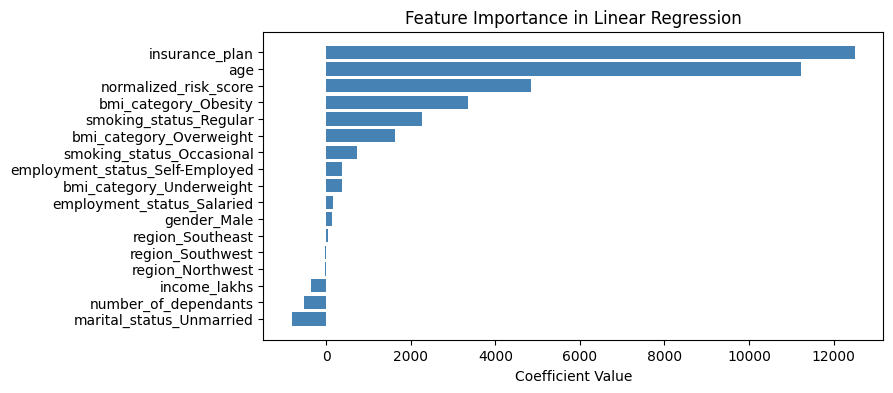

In [55]:
# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [56]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9280956798900619, 0.9283764905001946)

In [57]:
y_pred = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test, y_pred)
rmse_rg = np.sqrt(mse_lr)

print("Ridge Regression ==> MSE:",mse_rg, "RMSE:",rmse_rg)

Ridge Regression ==> MSE: 5056646.815407014 RMSE: 2248.6972073509087


### RandomForest Regression Model

In [58]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
train_score = model_rf.score(X_train, y_train)
test_score = model_rf.score(X_test, y_test)
train_score, test_score

(0.9965551443383076, 0.9790381655420375)

In [59]:
y_pred = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Regressor ==> MSE:", mse_rf, "RMSE:", rmse_rf)

Random Forest Regressor ==> MSE: 1479913.4278282342 RMSE: 1216.5169245958866


In [60]:
model_rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None], 
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(model_rf, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='r2')

In [61]:
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

0.9812989071665325
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)


In [62]:
best_model = random_search.best_estimator_

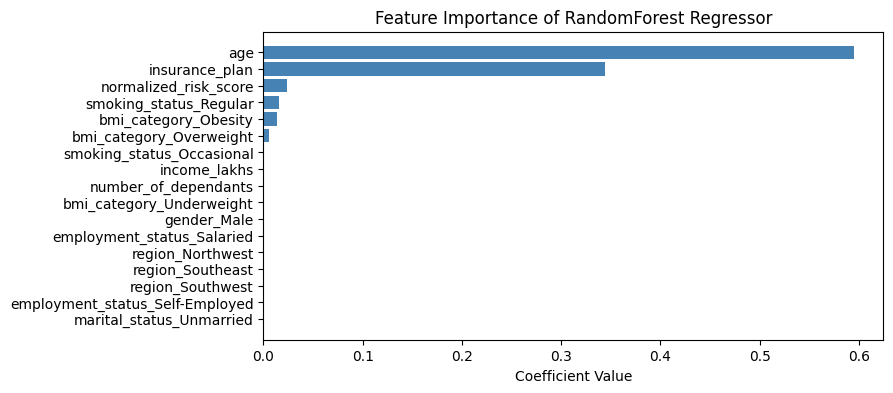

In [63]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance of RandomForest Regressor')
plt.show()

### XGBoost

In [64]:
model_xgb = XGBRegressor(n_estimators=100, max_depth=3)
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.982200026512146, 0.9817335605621338)

In [65]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)

print("Random Forest Regressor ==> MSE:", mse_xgb, "RMSE:", rmse_xgb)

Random Forest Regressor ==> MSE: 1289619.6325388746 RMSE: 1135.6142093769674


In [66]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50,100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50, 100]},
                   random_state=42, scoring='r2')

In [67]:
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

0.9818491538365682
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [68]:
best_model = random_search.best_estimator_

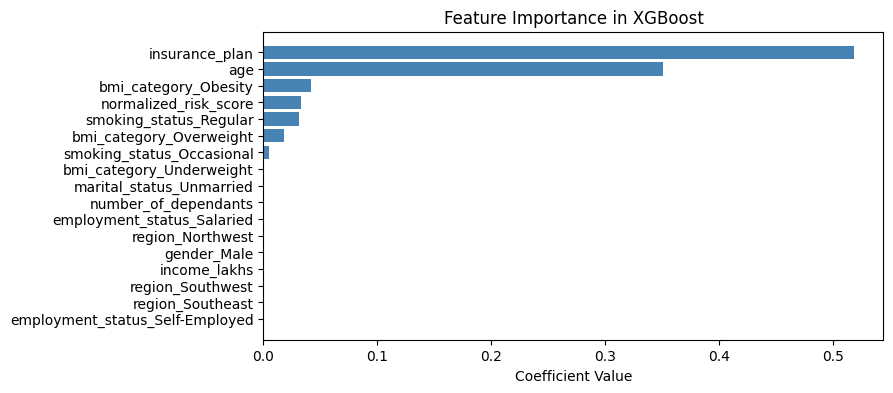

In [69]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

<h2 align="center" style="color:blue">Error Analysis</h2>

In [70]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

residuals_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
residuals_df.head()

,actual,predicted,diff,diff_pct
24098,9246,9115.173828,-130.826172,-1.414949
201,11664,13373.257812,1709.257812,14.654131
25471,10472,7379.569336,-3092.430664,-29.530469
32500,26267,25897.628906,-369.371094,-1.406217
30832,9106,9119.539062,13.539062,0.148683


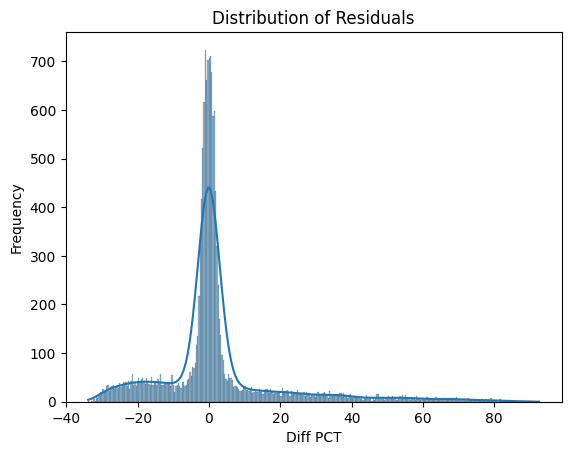

In [71]:
sns.histplot(residuals_df['diff_pct'], kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Diff PCT")
plt.ylabel('Frequency')
plt.show()

In [72]:
extreme_error_threhold = 10
extreme_results_df = residuals_df[np.abs(residuals_df['diff_pct']) > extreme_error_threhold]
extreme_results_df

,actual,predicted,diff,diff_pct
201,11664,13373.257812,1709.257812,14.654131
25471,10472,7379.569336,-3092.430664,-29.530469
47939,11996,13630.340820,1634.340820,13.624048
26239,4436,6443.061523,2007.061523,45.244849
16907,8952,11095.924805,2143.924805,23.949115
...,...,...,...,...
41535,12253,10352.640625,-1900.359375,-15.509340
21893,9260,7917.165039,-1342.834961,-14.501457
37321,9087,6460.343750,-2626.656250,-28.905648
43822,4407,7361.885254,2954.885254,67.049813


In [73]:
extreme_results_df.shape

(4393, 4)

In [74]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

29.3394777265745

We have 30% extreme errors which means for 30% customers we will either overchange or underchange by 10% or more

In [75]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
22007,3627,6984.692383,3357.692383,92.574921
29446,3546,6743.144043,3197.144043,90.161987
23975,3520,6649.224121,3129.224121,88.898413
13179,3620,6820.528320,3200.528320,88.412385
41181,3593,6748.015137,3155.015137,87.810051
...,...,...,...,...
29632,4315,6485.318359,2170.318359,50.297065
49008,5503,8268.371094,2765.371094,50.252064
23574,4330,6505.912109,2175.912109,50.252012
9318,4941,7423.098633,2482.098633,50.234743


There will be about 513 customers whom we will overchange or underchange by more than 50%

In [76]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
201,0.129630,0.2,0.636364,1.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0
25471,0.074074,0.0,0.010101,0.0,0.0,1,1,0,0,1,0,1,0,0,1,1,0
47939,0.111111,0.0,0.424242,1.0,0.0,0,1,0,0,1,0,0,1,0,0,1,0
26239,0.037037,0.0,0.292929,0.0,0.0,1,1,0,0,1,0,0,1,0,0,0,0
16907,0.111111,0.0,0.606061,0.5,0.0,1,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41535,0.129630,0.4,0.505051,0.5,0.0,0,1,0,0,1,0,1,0,1,0,0,0
21893,0.129630,0.4,0.242424,0.0,0.0,1,0,1,0,1,1,0,0,0,1,0,0
37321,0.018519,0.4,0.171717,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0
43822,0.111111,0.2,0.020202,0.0,0.0,0,0,1,0,1,1,0,0,0,0,0,0


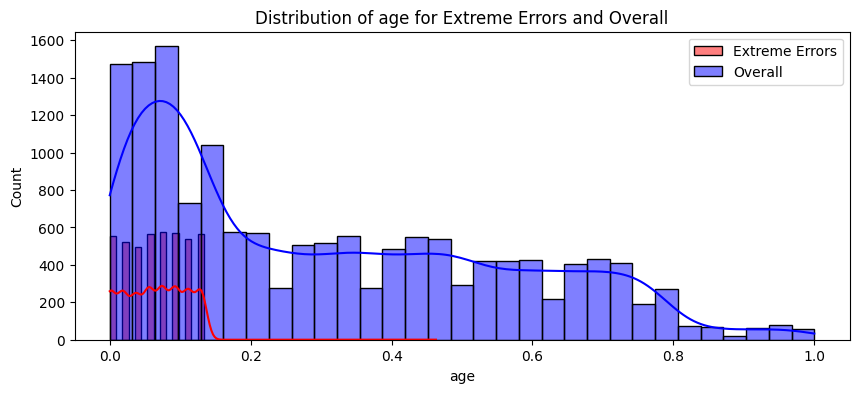

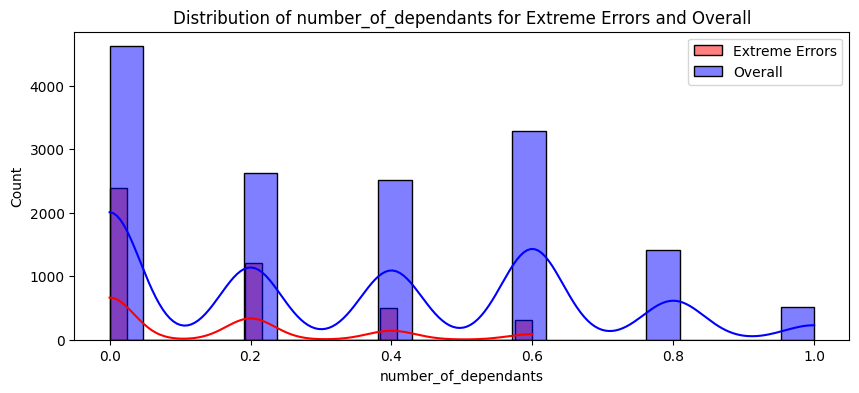

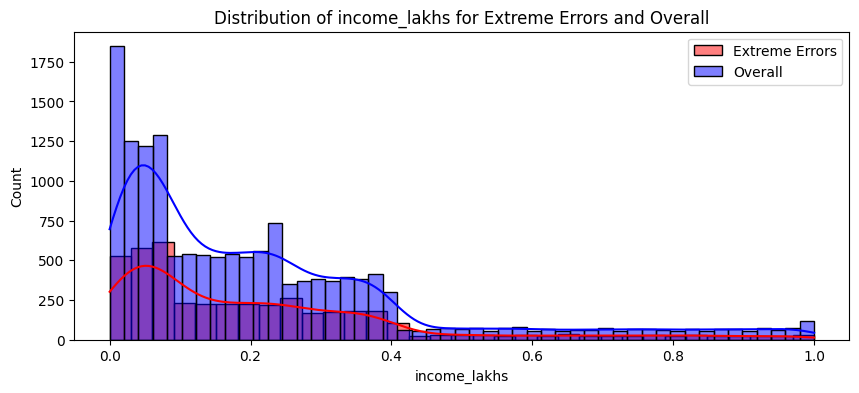

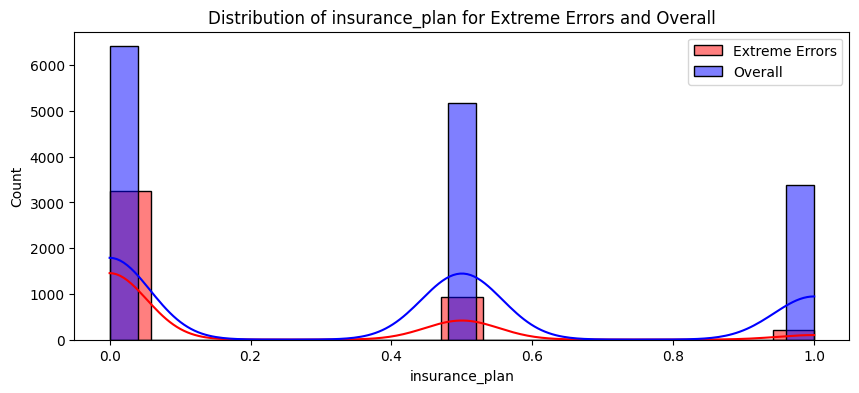

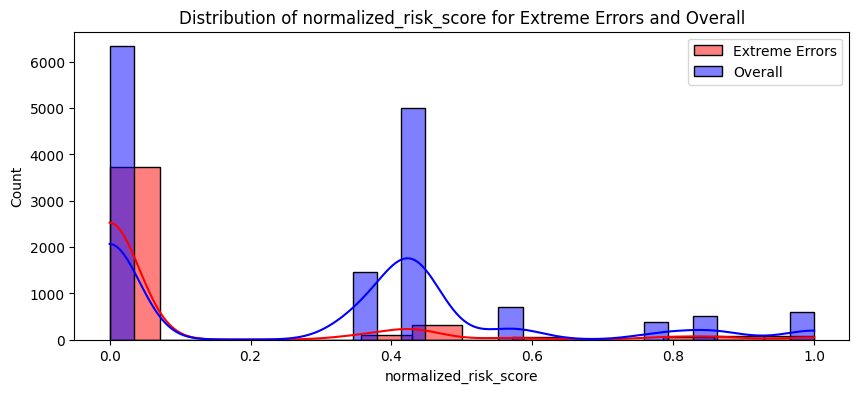

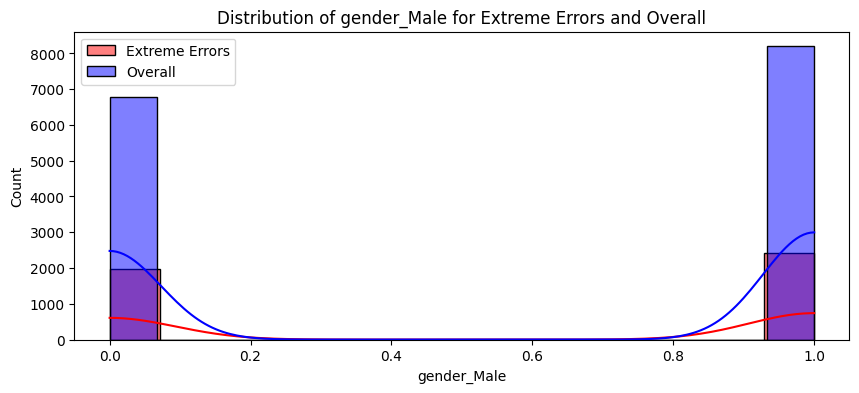

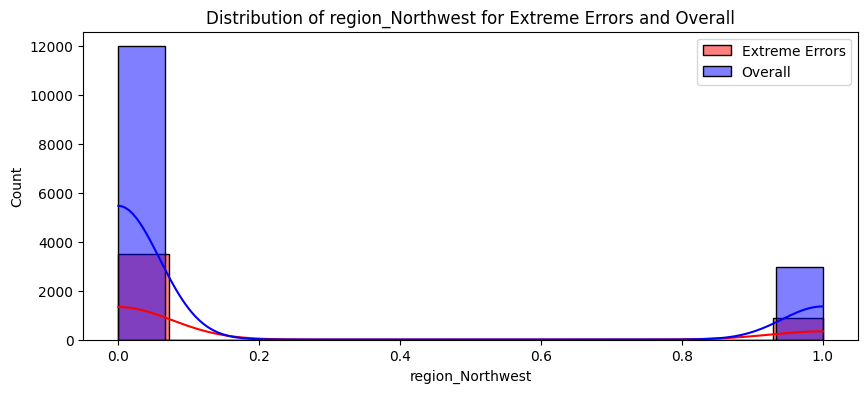

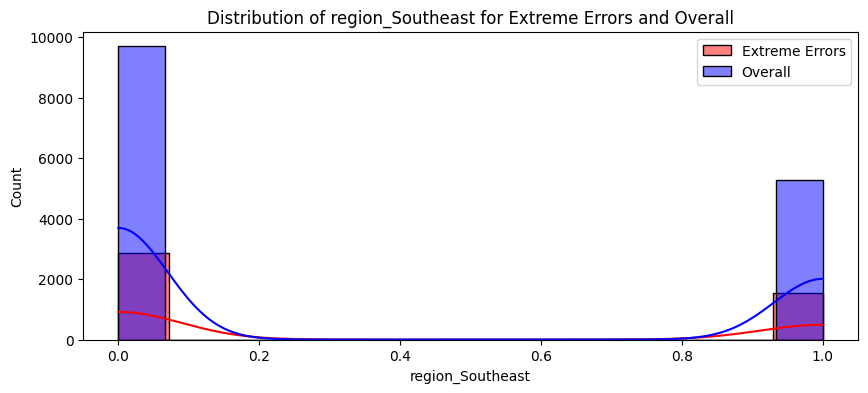

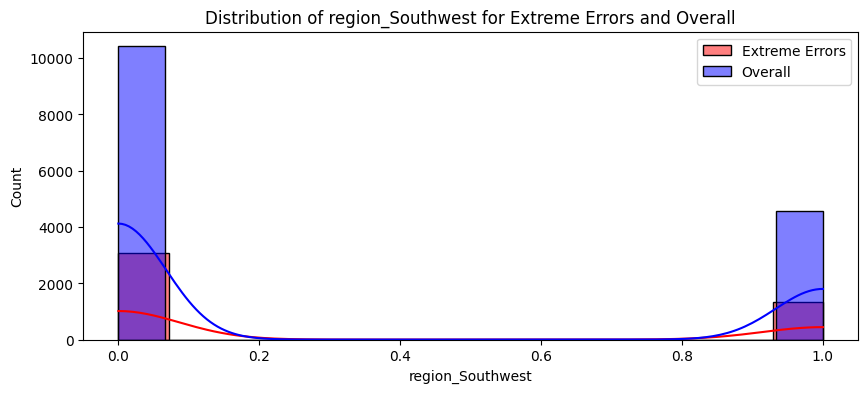

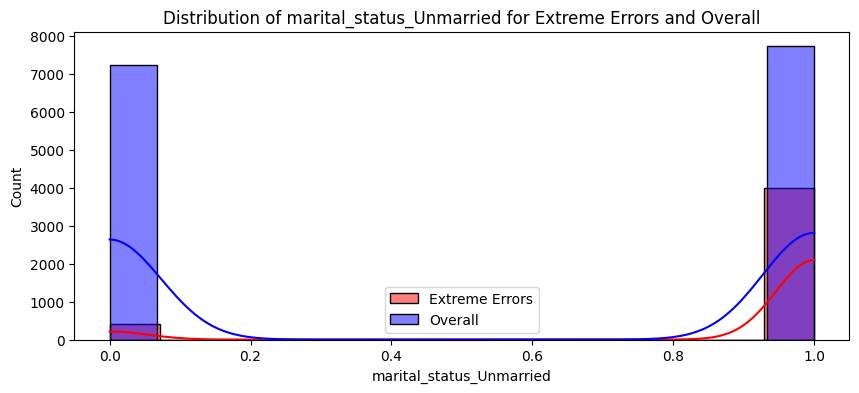

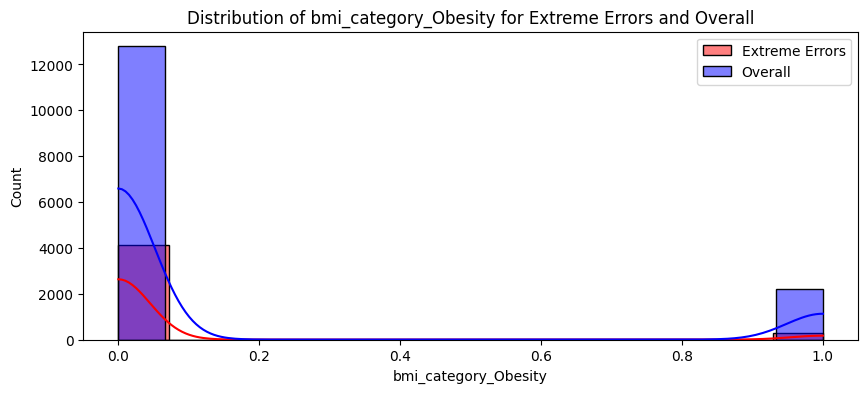

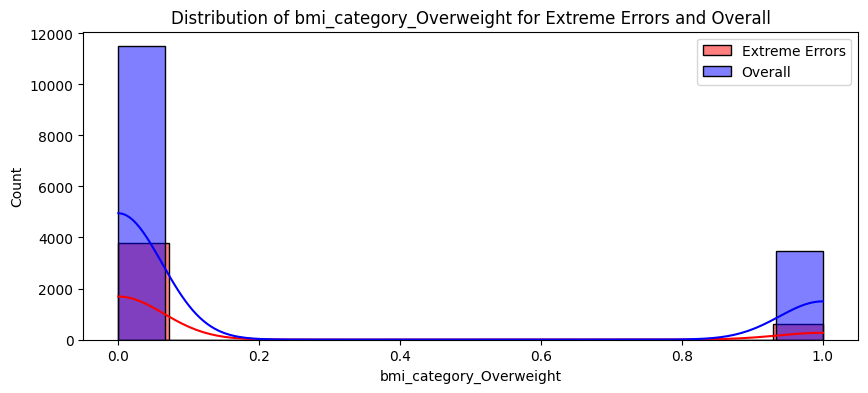

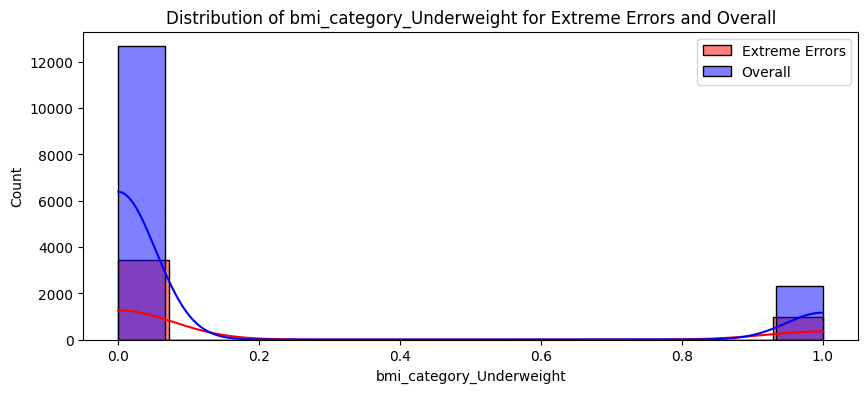

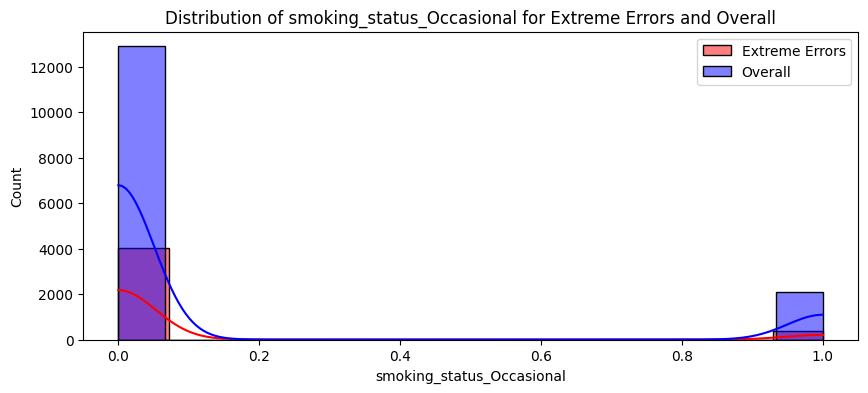

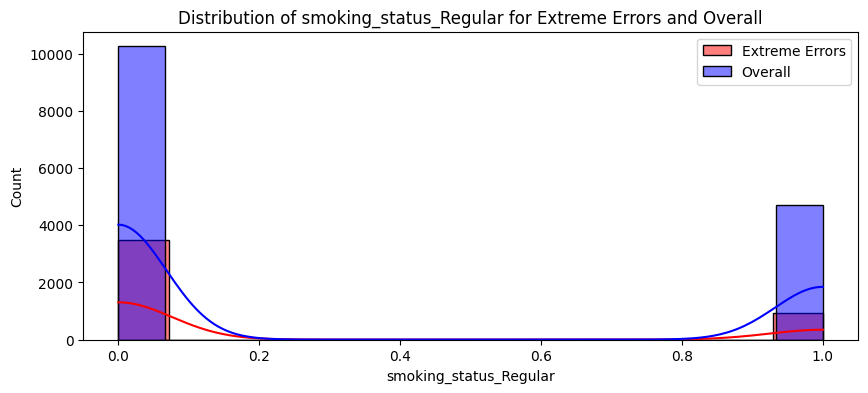

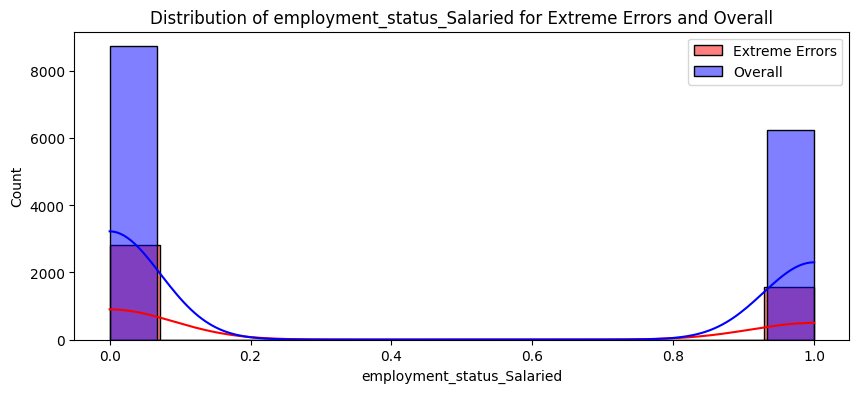

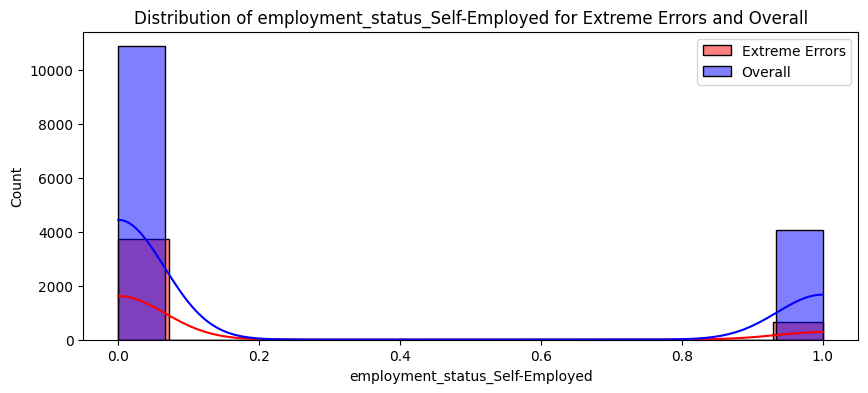

In [77]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[feature], color='red', label="Extreme Errors", kde=True)
    sns.histplot(X_test[feature], color="blue", label="Overall", alpha=0.5, kde=True)
    plt.legend()
    plt.title(f"Distribution of {feature} for Extreme Errors and Overall")
    plt.show()

### Reverse Scaling

In [78]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [79]:
extreme_errors_df['income_level'] = -1

In [80]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,25.0,1.0,-2.0,64.0,3.0
1,22.0,0.0,-2.0,2.0,1.0
2,24.0,0.0,-2.0,43.0,3.0
3,20.0,0.0,-2.0,30.0,1.0
4,24.0,0.0,-2.0,61.0,2.0


In [81]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4393.000000,4393.000000,4393.0,4393.000000,4393.000000
mean,21.564990,0.711359,-2.0,21.986797,1.311860
std,2.353237,0.924027,0.0,21.217492,0.561101
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,16.000000,1.000000
75%,24.000000,1.000000,-2.0,31.000000,2.000000
max,43.000000,3.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

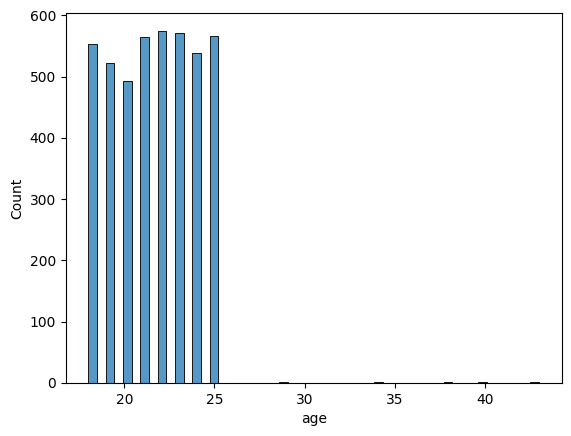

In [82]:
sns.histplot(df_reversed.age)

This shows that majority of the extreme errors are coming from young age group (i.e. <25 years of age). We need to may be build a separate model for this segment.